# How to use BigSur for feature selection

This tutorial goes over how to start using BigSur and some advanced usecases. This notebook assumes that that BigSur and scanpy are already installed, and that the user is already familiar with the standard scanpy pipeline (which you can brush up on [here](https://scanpy.readthedocs.io/en/stable/tutorials/index.html)). We explain how to download and install BigSur in the [README](README.md) file. 

If you're just starting out, we suggest looking at the [BigSur quickstart](#bigsur-quickstart) section first. When you're ready to use BigSur on datasets with groups of cells that are difficult to separate (cells that are similar in gene expression, e.g. cells of the same cell type), we suggest the [Different usecases](#different-usecases) section for concrete code examples. If BigSur is throwing Exceptions, please check out the [Troubleshooting](#troubleshooting) section. Finally, we have some advanced examples of using BigSur, such as using the statistics BigSur calculates directly to select features, and how to use the residuals we calculate for clustering, in the [Advanced usage](#advanced-usage) section. 

## Load functions

Load packages and functions that will be used throughout the notebook.

In [1]:
import scanpy as sc

from BigSur.feature_selection import mcfano_feature_selection # This is the BigSur feature selection function. If this step fails, BigSur is improperly installed. Consult the README file for installation details.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib import ticker

%matplotlib inline
sc.set_figure_params(dpi=100)

## Setup adata

We will be using the 10x Genomics 10k PBMC 3' end data (which is included in the BigSur download). The following block of code loads in the count data into an AnnData object and does some standard preprocessing and quality control. We also match cells with the cell type labels that were assigned in the paper. 

When running this block, you may get a warning that variable names (gene names) are not unique after running the first line; this is fixed in the subsequent line. A step that should not be ignored is saving the count data to a separate layer before log-normalization. BigSur takes as input count data, so the count data must be saved in a different layer before log-normalization. 

In [ ]:
# Load data
pbmc = sc.read_10x_h5('10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in pbmc data
pbmc.var_names_make_unique() # Make variable names unique

# Quality control
sc.pp.filter_cells(pbmc, min_genes=400)
sc.pp.filter_genes(pbmc, min_cells=3)

# Copy count data to a layer before normalization
pbmc.layers['counts'] = pbmc.X.copy() # Remember to copy counts
sc.pp.normalize_total(pbmc, target_sum=1e4) # Divides the expression values by the total counts per cell then multiplies by 1e4
sc.pp.log1p(pbmc) # Adds 1 to the expression values and takes the natural logarithm

# Label cells using the labels determined in the paper
pbmc_cell_labels = pd.read_csv('Figure1_panel_A_PBMC_metadata.csv', index_col='Barcode')
pbmc.obs['Celltype'] = pbmc_cell_labels['Celltype'].copy()

/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## BigSur quickstart

Now we're ready to run BigSur. The necessary parameters to specify are the AnnData and the layer in the AnnData where the counts are stored. Note that BigSur takes in counts, not normalized data; it will error if genes with zero means weren't filtered or if the elements in the counts matrix aren't integers. See the [Troubleshooting](#troubleshooting) section for more information. 

There are many parameters that can be used when calling BigSur. We only discuss some of these in this document, the rest can be found in the [docstring section](#docstring-of-feature-selection-function). Here, we will run the function with verbose = 2. 

In [3]:
mcfano_feature_selection(pbmc, layer='counts', verbose = 2) # Specify where the counts matrix is stored in the AnnData object with the "layer" parameter.

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
Calculating modified corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.55.
After fitting, cv = 0.55
Finished calculating modified corrected Fano factors for 22300 genes in 4.684883 seconds.
Calculating p-values.
Finished calculating p-values in 6.361204 seconds.
There are 11893 cells with a median sequencing depth of 6927.0 UMI/cell. Since 25% of mcFanos are significant, we suggest selecting the top 10% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.9.
Setting 1631 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HGD' 'HIST1H2AC'
 'HIST1H3H' 'HOPX' 'IFI27' 'IGHA1' 'IGHD' 'IGHG

If verbose = 2, BigSur prints what it is doing (calculating modified corrected Fano factors (or mcFano factors), calculating $p$-values), how long each step takes, and some useful outputs. In particular, it prints different statistics of the dataset (in this case, the dataset has 11893 cells with a median squencing depth of 6927 UMI/cell), and suggests cutoffs of the mcFano factors based on those statistics. We get more in depth with how to interpret these statistics later on in the [Different usecases](#different-usecases) section; for now, just know that these are suggestions, and that these suggested cutoffs are **not automatically used** by the method when features are selected -- in other words, if you want to change the cutoffs to match these suggestions, the code needs to be rerun with those cutoffs specified. 

BigSur also prints the genes with the 100 greatest significant mcFano factors. At a glance, we can see that there are many immune genes on this list, some of which are marker genes (for example, the granzyme genes point to the presence of CD8+ T cells, NKG7 is a gene expressed by NK cells, the immunoglobulin genes suggest the presence of B cells, etc.).

Once features are selected, we can calculate PCA, reduce dimensions, build the KNN graph, calculate the UMAP coordinates and assign clusters. We should note that the top 50 PCs are used when selecting PCs and resolution = 1 when assigning clusters using the Leiden algorithm. You can consult the documentation of `sc.pp.pca` and `sc.tl.leiden` if you want to change these parameters. Finally, when running the Leiden algorithm, you may get warnings regarding "IProgress not found" and FutureWarnings; these are not relevant to BigSur and can be safely ignored. 

In [4]:
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.tl.leiden(pbmc)

/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/rk/963s32ts3r7clhq0w3ccryjr0000gn/T/ipykernel_11215/285637629.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(pbmc)


Finally, we can visualize the clusters using UMAP.

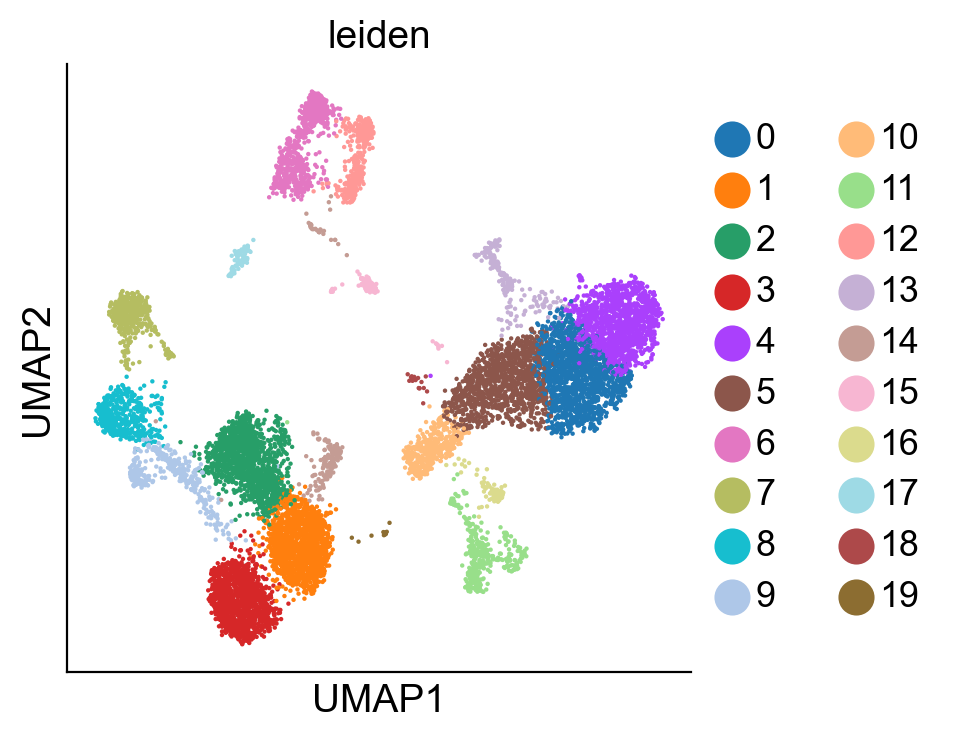

In [5]:
sc.pl.umap(pbmc, color=['leiden'])

You're ready to use BigSur! Read the next section for how and when to select different cutoffs.

# Different usecases

This section details how to pick cutoffs in different cases using the suggestions that BigSur prints during calculations.

## How to pick cutoffs

Determining how to select the correct $\phi'$ and $p$-value cutoffs for a particular dataset depends on many aspects of the dataset, some of which are not knowable. To select the number of features, we first calculate two of the knowable statistics on which correct feature selection will depend: the number of cells and the median sequencing depth. If there are insufficient numbers of cells (less than 150, say) or the dataset is shallowly sequenced (for example, less than 3000 UMI/cell), then feature selection becomes very difficult. In these cases, we suggest selecting the top 10% of $\phi'$ that are significant, and carefully studying the results for biological meaning. If, on the other hand, the dataset has sufficient numbers of cells and sequencing depth, we then calculate the percent of $\phi'$ that are significant, which is an approximation of the homogeneity of the dataset. If there are more than 5% of $\phi'$ that are significant (i.e. the dataset can be considered to be heterogenous), we suggest selecting the top 10% of $\phi'$ that are significant, and if not, we suggest selecting the top 1%. Note that the function will suggest cutoffs if the verbose parameter is set to 2.

## Preparation of this section

There are many analysis steps for this section. Some of these steps, such as the calculation of enrichment we use to show the impact different feature selection can have on clustering, is not useful to understand how to use BigSur. We relegate these calculations to this section. This section can be safely skipped if you're not interested in learning about how we calculate enrichment and just want to focus on how to use BigSur. 

#### CD8+ T cell subsetting

In [6]:
cd8_t_cells = pbmc[pbmc.obs['Celltype'].isin(['CD8+ T Cells'])].copy()

sc.pp.filter_cells(cd8_t_cells, min_genes=400)
sc.pp.filter_genes(cd8_t_cells, min_cells=3)
mcfano_feature_selection(cd8_t_cells, layer='counts', min_mcfano_cutoff=0.99, verbose = 0)
sc.pp.pca(cd8_t_cells)
sc.pp.neighbors(cd8_t_cells)
sc.tl.umap(cd8_t_cells)
sc.tl.leiden(cd8_t_cells)

#### Calculate UMAPs for the 10k PBMC dataset and the CD8+ T cell dataset, without reassigning the clusters

In [7]:
def calculate_umap_using_different_cutoffs(adata, bigsur_parameters_dict):
    '''This function selects features using different mcFano cutoffs and recalculates the UMAPs.'''
    adata_copy = adata.copy()

    mcfano_feature_selection(adata_copy, layer='counts', **bigsur_parameters_dict) 
    sc.pp.pca(adata_copy)
    sc.pp.neighbors(adata_copy)
    sc.tl.umap(adata_copy)

    return adata_copy

In [8]:
adata_dict_pbmc = {}
adata_dict_cd8 = {}

for mcfano_cutoff in [0.9, 0.99]:
    adata_dict_pbmc[f'mcfano quantile cutoff = {mcfano_cutoff}'] = calculate_umap_using_different_cutoffs(pbmc, {'min_mcfano_cutoff':mcfano_cutoff, 'verbose':1})
    adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}'] = calculate_umap_using_different_cutoffs(cd8_t_cells, {'min_mcfano_cutoff':mcfano_cutoff, 'verbose':1})

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15
Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


#### Calculating of the enrichment of T cell marker for the PBMC dataset, and the memory CD8+ T cell marker for the CD8+ T cell dataset

In [9]:
def calculate_enrichment(adata, gene, starting_seed = 0):
    '''This function assigns clusters (using the starting seed) and calculates the enrichment of the specified gene for each cluster.'''
    adata_copy = adata.copy()
    sc.tl.leiden(adata_copy, random_state=starting_seed)
    df = sc.get.obs_df(adata_copy, keys = [gene, 'leiden'])
    df_enrichment_temp = df.groupby('leiden', observed=False).mean() / df[gene].mean()
    df_enrichment_temp['mcfano quantile cutoff'] = f'{mcfano_cutoff}'
    df_enrichment_temp['Random seed'] = starting_seed

    return df_enrichment_temp

In [10]:
gene = 'CD3E'
df_enrichment_pbmc = pd.DataFrame()

for mcfano_cutoff in [0.9, 0.99]:
    adata = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}']
    df_temp = calculate_enrichment(adata, gene, starting_seed = 0)
    df_enrichment_pbmc = pd.concat([df_enrichment_pbmc, df_temp])

In [11]:
gene = 'CCL5'
rng = np.random.default_rng()
df_enrichment_cd8 = pd.DataFrame()

for mcfano_cutoff in [0.9, 0.99]:
    adata = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}']
    df_temp = calculate_enrichment(adata, gene, starting_seed = 0)
    df_enrichment_cd8 = pd.concat([df_enrichment_cd8, df_temp[df_temp['CCL5'].max() == df_temp['CCL5']]])

    for iteration in range(40):
        seed = rng.choice(adata.shape[0])
        df_temp = calculate_enrichment(adata, gene, starting_seed = seed)
        df_enrichment_cd8 = pd.concat([df_enrichment_cd8, df_temp[df_temp['CCL5'].max() == df_temp['CCL5']]])

## Usecase where cutoffs don't particularly matter

Here, we will rerun BigSur on the full 10k PBMC dataset. We will run this with verbose = 2 to see what cutoffs BigSur suggests we use. 

In [12]:
mcfano_feature_selection(pbmc, layer='counts', verbose = 2) 

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
Calculating modified corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.55.
After fitting, cv = 0.55
Finished calculating modified corrected Fano factors for 22300 genes in 4.293094 seconds.
Calculating p-values.
Finished calculating p-values in 4.803308 seconds.
There are 11893 cells with a median sequencing depth of 6927.0 UMI/cell. Since 25% of mcFanos are significant, we suggest selecting the top 10% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.9.
Setting 1631 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HGD' 'HIST1H2AC'
 'HIST1H3H' 'HOPX' 'IFI27' 'IGHA1' 'IGHD' 'IGHG

In this case, BigSur suggests we use the top 10% of $\phi'$ that are significant (which is the default). That being said, let's compare the UMAPs calculated on the top 10% and the top 1% of $\phi'$ that are significant. We've already assigned clusters using the top 10% of $\phi'$ that are significant in the [BigSur quickstart](#bigsur-quickstart) section, so let's compare how those clusters group together in the UMAPs calculated using either set of selected features. 

In [13]:
# Calculate UMAPs with different feature selection cutoffs
adata_dict_pbmc = {}

for mcfano_cutoff in [0.9, 0.99]:
    adata = pbmc.copy()
    mcfano_feature_selection(adata, layer='counts', min_mcfano_cutoff=mcfano_cutoff) # the min_mcfano_cutoff parameter specifies the cutoff parameter
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    adata_dict_pbmc[f'mcfano quantile cutoff = {mcfano_cutoff}'] = adata

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


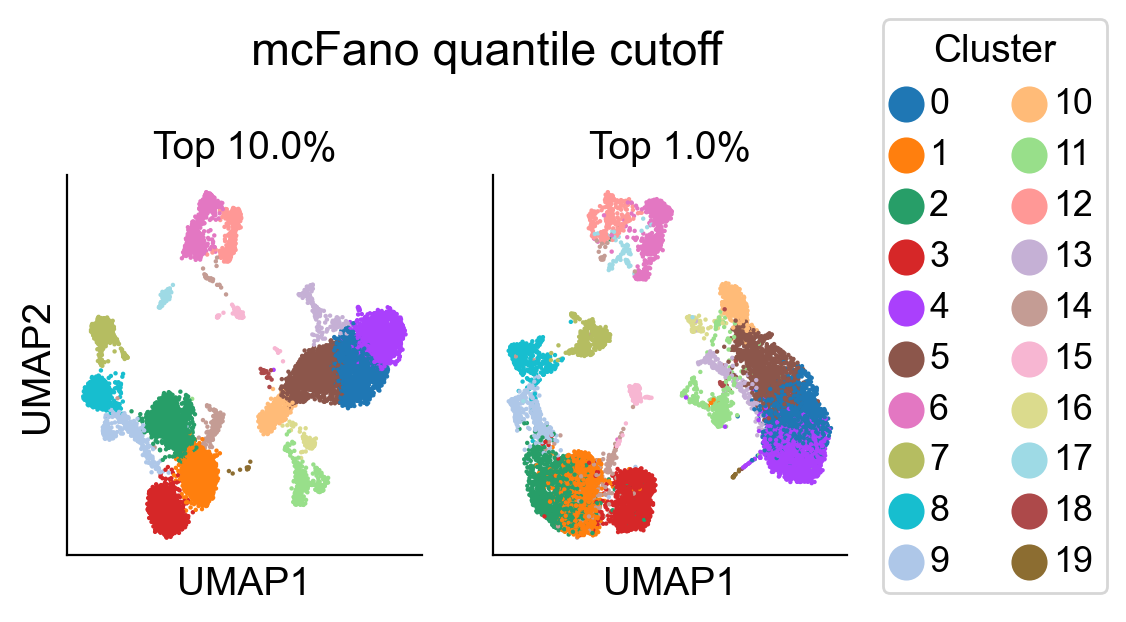

In [14]:
fig, axes = plt.subplots(1,2, figsize = (5, 2.5))

for col, mcfano_cutoff in enumerate([0.9, 0.99]):
    # prep plot
    ax = axes[col]
    adata_copy = adata_dict_pbmc[f'mcfano quantile cutoff = {mcfano_cutoff}']
    
    # plot umap
    sc.pl.umap(adata_copy, color = 'leiden', ax = ax, show = False)
    
    # Plot fixes

    ## x axis

    ## y axis
    if col != 0:
        ax.set_ylabel('')

    ## Title
    ax.set_title(f'Top {np.round((1 - mcfano_cutoff)*100, 1)}%')

    ## Legend
    if (col == 1):
        ax.legend(loc = (1.1, -0.1), ncol = 2, title = 'Cluster')

    else:
        ax.legend().remove()

# Suptitle
fig.suptitle('mcFano quantile cutoff', y = 1.2, x = 0.6)

plt.show()

The clusters are less separated if the $\phi'$ cutoff is set to 1%, but they are still distinguishable, and the groups of cells that consist of multiple clusters (i.e., the "cell types") are still well separated. 

### The effect of varying cutoffs on the cluster assignments of T cells

In the paper, we defined an "enrichment score" which is the fold change in the average expression of each cluster of a gene to the average expression of that gene in all cells. We can use this score to quantify the effect changing the number of genes has on the ability to cluster the T cells together. The enrichment score was calculated in the [Preparation section](#preparation-of-this-section) (which can be skipped if you're just here to learn how to use BigSur).

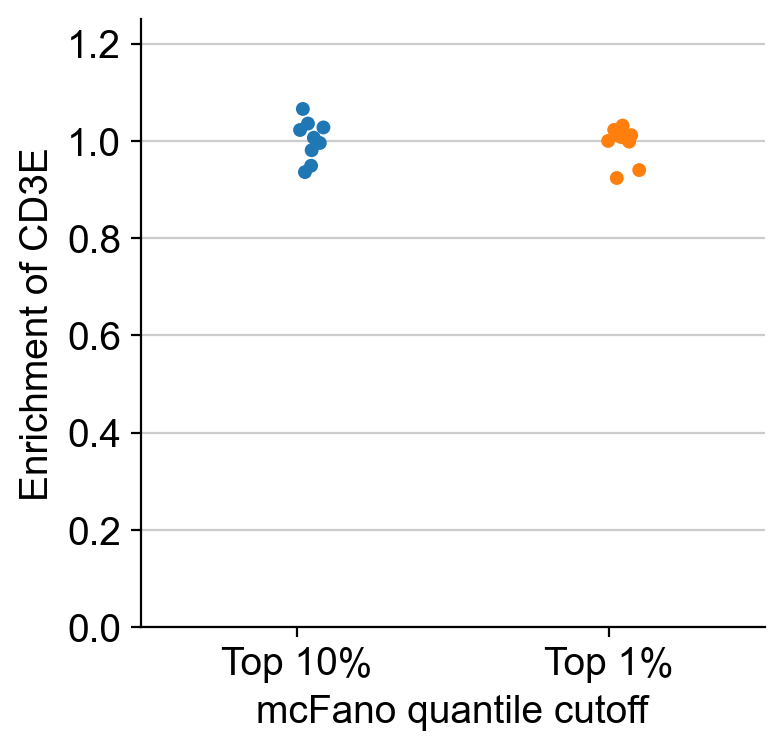

In [15]:
# Prep plot
fig, ax = plt.subplots()
color_palette = {cutoff:color for cutoff, color in zip(df_enrichment_pbmc['mcfano quantile cutoff'].unique(), sns.color_palette()[:4])}

# Plot
sns.stripplot(data = df_enrichment_pbmc, x = 'mcfano quantile cutoff', y = 'CD3E', hue = 'mcfano quantile cutoff', ax = ax, palette = color_palette)

# Plot fixes
## x axis
ax.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['Top 10%', 'Top 1%']))
ax.set_xlabel('mcFano quantile cutoff')

ax.set_ylim([0, 1.25])
ax.set_ylabel('Enrichment of CD3E')

plt.show()

The enrichments of the clusters are similar, regardless of which cutoff is used. 

## Usecase where feature selection _will_ influence the result

To show the impact feature selection can have when trying to separate similar groups of cells, we will subset and analyze the memory CD8+ T cells identified in the paper. 

In [16]:
cd8_t_cells = pbmc[pbmc.obs['Celltype'].isin(['CD8+ T Cells'])].copy() # Labels were provided in the quickstart section

sc.pp.filter_cells(cd8_t_cells, min_genes=400)
sc.pp.filter_genes(cd8_t_cells, min_cells=3) # Remember to filter genes

Let's now run BigSur with verbose = 2 to see what the suggested cutoffs are. 

In [17]:
mcfano_feature_selection(cd8_t_cells, layer='counts', verbose = 2)

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
Calculating modified corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.15.
After fitting, cv = 0.15
Finished calculating modified corrected Fano factors for 15186 genes in 0.151748 seconds.
Calculating p-values.
Finished calculating p-values in 1.161859 seconds.
There are 1384 cells with a median sequencing depth of 6708.5 UMI/cell. Since 5% of mcFanos are significant, we suggest selecting the top 1% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.99.
Setting 516 genes as highly variable.
Top 100 selected genes: 
 ['AC011498.1' 'AC092903.2' 'AC107027.3' 'AC108134.2' 'AC246817.2' 'ACTB'
 'ACTG1' 'AL160314.2' 'AL590705.1' 'AL603756.1' 'ANXA1' 'BCL11A' 'CACNB4'
 'CCDC168' 'CCL5' 'CDK6' 'CEP290' 'CRIP1' 'CST7' 'CXXC5' 'CYB5D2' 'FAM30A'
 'FTL' 'FXYD2' 'GOLGA4' 'GPR183' 'GTSCR1' 'GZMA' 'GZMK' 'H1FX' 'HOPX'
 'ID2' 'IFI27' 'IFI44L' 'IGHM' 'IGKC' 

The algorithm suggests that we use a cutoff of 0.99, or the top 1% of $\phi'$ that are significant. We can now rerun the algorithm with that cutoff. As an aside, if rerunning BigSur multiple times becomes onerous, please see the [Advanced usage](#advanced-usage) section for how to assign cutoffs manually. 

Before we rerun BigSur with the suggested cutoff, we can take a look at the list of genes above. Notice that CCL5, a marker of CD8+ memory T cells, is in the top 100 genes.

In [18]:
mcfano_feature_selection(cd8_t_cells, layer='counts', min_mcfano_cutoff=0.99, verbose = 1) # Rerun function, setting verbose = 1

Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


Now we can calculate UMAPs and assign clusters.

In [19]:
sc.pp.pca(cd8_t_cells)
sc.pp.neighbors(cd8_t_cells)
sc.tl.umap(cd8_t_cells)
sc.tl.leiden(cd8_t_cells)

Here, we set the mcfano quantile cutoff to 0.99 (i.e., we select the top 1% of significant $\phi$), as suggested by the algorithm.

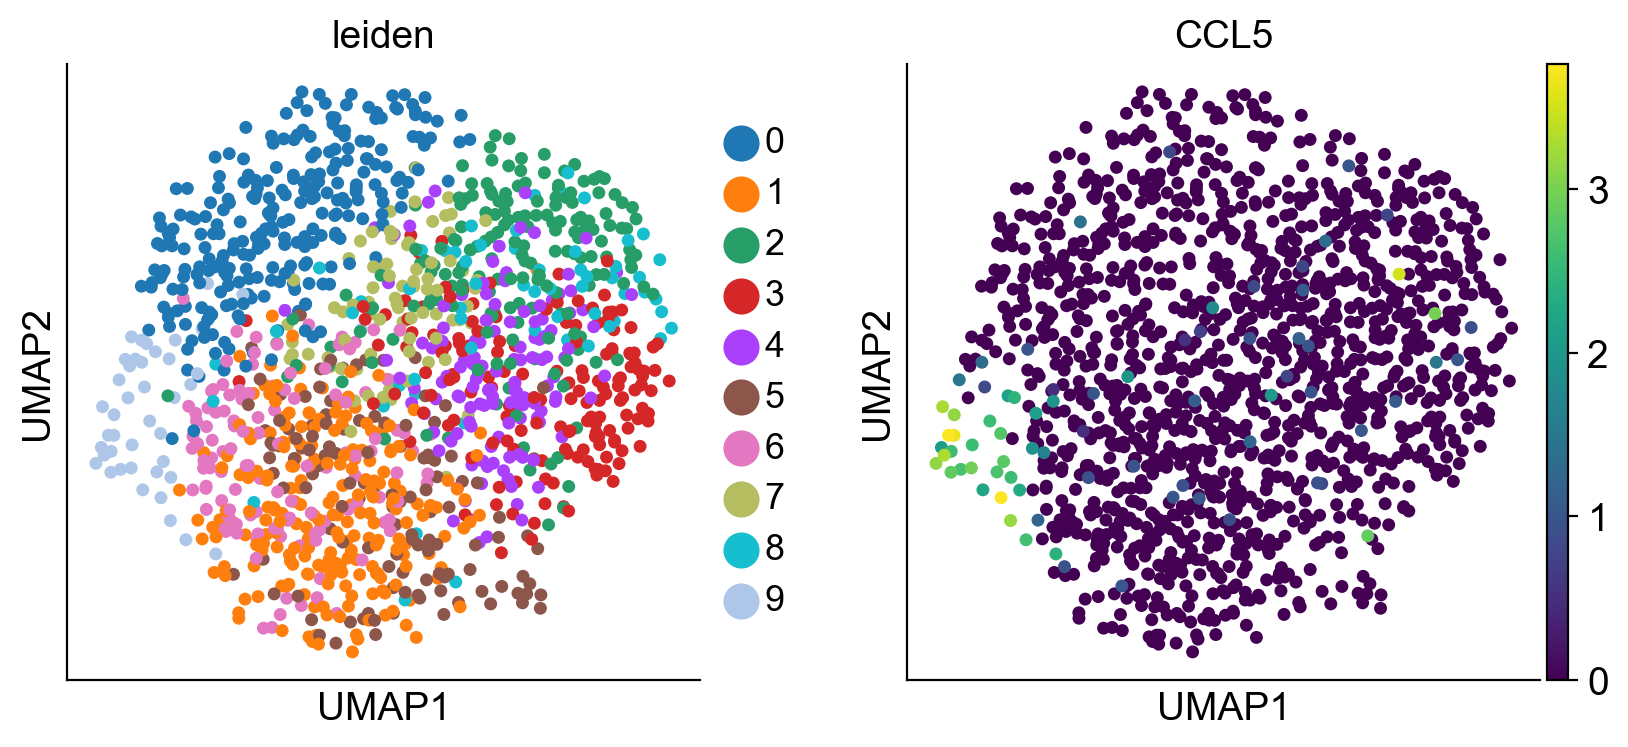

In [20]:
sc.pl.umap(cd8_t_cells, color = ['leiden', 'CCL5'])

We can observe that most of the cells expressing CCL5 are assigned to a single cluster, cluster 9. 

### The effect of varying cutoffs on the cluster assignments of CD8+ memory T cells

To quantify the effect of changing the number of features in this case, we can calculate the UMAPs on features selected using different cutoffs (as in the example above). However, unlike in the previous section, we will re-assign the Leiden clusters after features are selected using the different cutoffs. 

In [21]:
# Calculate UMAPs with different feature selection cutoffs
adata_dict_cd8 = {}

for mcfano_cutoff in [0.9, 0.99]:
    adata = cd8_t_cells.copy()
    mcfano_feature_selection(adata, layer='counts', min_mcfano_cutoff=mcfano_cutoff) # the min_mcfano_cutoff parameter specifies the cutoff parameter
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added = 'leiden_recalculated') # Re-assign clusters

    adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}'] = adata

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15
Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


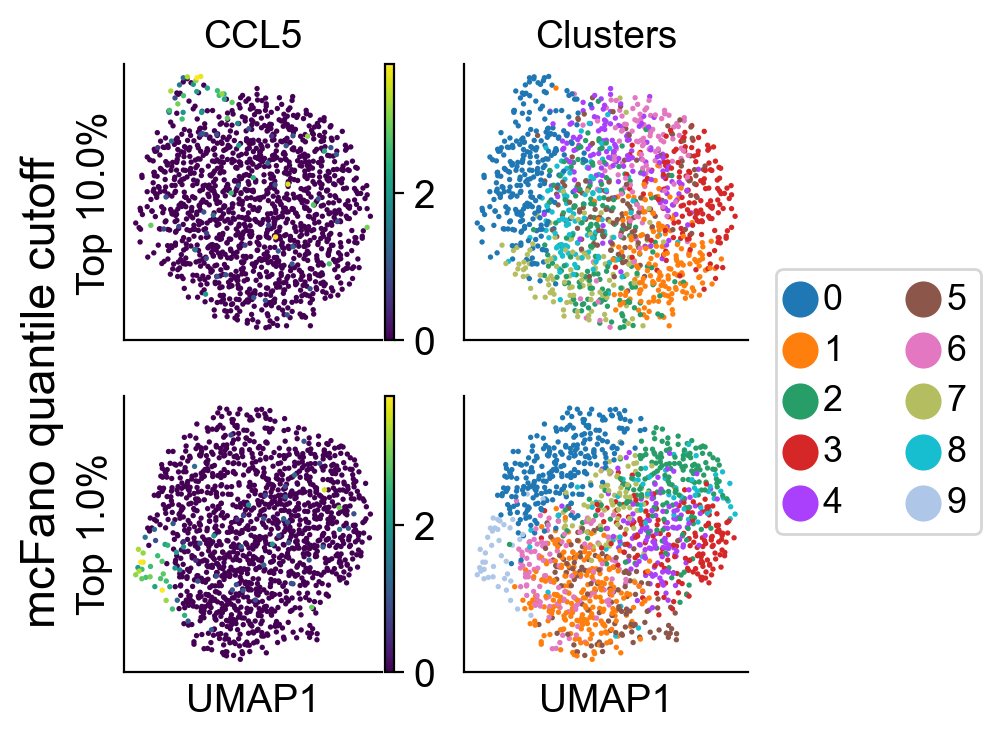

In [22]:
fig, axes = plt.subplots(2,2)

for row, mcfano_cutoff in enumerate([0.9, 0.99]):
    
    adata_copy = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}'].copy()

    for col, color in enumerate(['CCL5', 'leiden_recalculated']):
        # prep plot
        ax = axes[row, col]
        # plot umap
        sc.pl.umap(adata_copy, color = color, ax = ax, show = False, s = 15)

        # Plot fixes
        ## x axis
        if row != 1:
            ax.set_xlabel('')

        ## y axis
        if col != 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel(f'Top {(1-mcfano_cutoff)*100:.1f}%')

        ## Title
        if (row == 0):
            if (col == 0):
                ax.set_title(f'CCL5')
            else:
                ax.set_title(f'Clusters')

        else:
            ax.set_title('')


        ## Legend
        if (row == 1) and (col == 1):
            ax.legend(loc = (1.1, 0.5), ncol = 2, title = '')

        elif (row == 0) and (col == 1):
            ax.legend().remove()

fig.supylabel('mcFano quantile cutoff', x = 0.05, y = 0.5)

plt.show()

We can see that the CCL5+ cluster found when selecting only the top 1% of $\phi'$ that are significant is no longer present when using the top 10% of $\phi'$ that are significant. However, the cells highly expressing CCL5 seem to still be grouping together on the UMAP, implying that a change of parameters could have resulted in these cells being assigned with high specificity to one cluster. One such parameter is the starting seed of the Leiden algorithm. Since the Leiden algorithm is stochastic, a starting seed is specified to ensure reproducible results. As we discuss in the paper, changing this starting seed can change the cluster assignments. We assessed the effect the choice of starting seed had on enrichment below. 

For each set of selected features, 40 different starting seeds of the Leiden algorithm were selected and clusters were subsequently assigned. For each set of clusters, we calculated the enrichment of CCL5 and plotted the maximum enrichment. 

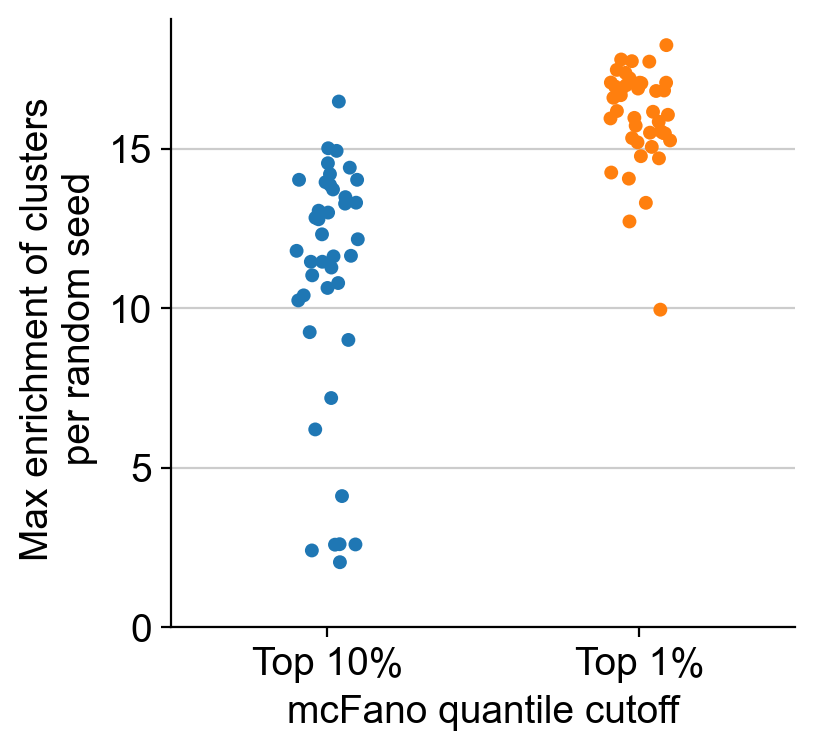

In [23]:
# Prep plot
fig, ax = plt.subplots()
color_palette = {cutoff:color for cutoff, color in zip(df_enrichment_cd8['mcfano quantile cutoff'].unique(), sns.color_palette()[:4])}

# Plot
sns.stripplot(data = df_enrichment_cd8, x = 'mcfano quantile cutoff', y = 'CCL5', hue = 'mcfano quantile cutoff', ax = ax, palette = color_palette)

# Fix plot
## x axis
ax.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['Top 10%', 'Top 1%']))
ax.set_xlabel('mcFano quantile cutoff')

## y axis
ax.set_ylim([0, None])
ax.set_ylabel('Max enrichment of clusters \n per random seed')

plt.show()

We can see that the maximum enrichment when using a quantile cutoff of 0.99 is on average greater than when using a quantile cutoff of 0.9; in addition, we can see that the spread of enrichments is less sensitive to choice of random seed when selecting fewer genes. 

# Troubleshooting

Reimport adata for demonstration; there may again be warnings of variable names not being unique.

In [24]:
pbmc = sc.read_10x_h5('10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
pbmc.var_names_make_unique()
pbmc.layers['counts'] = pbmc.X.copy()

/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We require filtering genes before usage; if there are genes with no expression in the matrix, BigSur will throw an error.

In [25]:
try:
    mcfano_feature_selection(pbmc, layer='counts')
except Exception as err:
    print(f'Exception: {err}')

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
Exception: Zero gene means were found, remove genes with no counts before calculating mcFanos.


In [26]:
# Filter cells and genes
sc.pp.filter_cells(pbmc, min_genes=400)
sc.pp.filter_genes(pbmc, min_cells=3)

# Normalize data
sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)

We require passing counts, not normalized data. If the elements in the matrix are not integers, BigSur will throw an error. 

In [27]:
try:
    mcfano_feature_selection(pbmc, layer='X')
except Exception as err:
    print(f'Exception: {err}')

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
Exception: This function takes raw counts, normalized data was passed.


The following code, however, does work:

In [28]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1)

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


# Advanced usage

## Storage of $\phi'$, $p$-values and "highly variable" genes 

The $\phi'$ and their FDR-corrected $p$-values are stored in the var dataframe:

In [29]:
pbmc.var[['mc_Fano', 'FDR_adj_pvalue']].head()

,mc_Fano,FDR_adj_pvalue
AL627309.1,1.254207,0.286164
AL627309.3,1.110905,0.631812
AL627309.5,0.978634,0.844089
AL627309.4,1.074729,0.643346
AL669831.2,0.734430,0.892634


Whether a gene meets the specified cutoff is stored in the "highly_variable" slot (such that it can be used for downstream scanpy functions):

In [30]:
print(pbmc.var[['highly_variable']])
pbmc.var.index[pbmc.var['highly_variable']] # Print genes that meet the cutoff

            highly_variable
AL627309.1            False
AL627309.3            False
AL627309.5            False
AL627309.4            False
AL669831.2            False
...                     ...
AL592183.1            False
AC240274.1            False
AC004556.3            False
AC233755.1            False
AC007325.4            False

[22300 rows x 1 columns]


Index(['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MMP23B', 'PLCH2', 'TNFRSF25',
       'UTS2', 'AL034417.3', 'RBP7',
       ...
       'PGRMC1', 'SH2D1A', 'TENM1', 'SMARCA1', 'FHL1', 'LINC00892', 'CD40LG',
       'PNMA3', 'PDZD4', 'MPP1'],
      dtype='object', length=1631)

## Using the stored slots to specify cutoffs manually

Instead of rerunning BigSur every time to vary the cutoffs, you can instead use these three slots to specify genes that meet a cutoff. For example, we can set all genes with $p$-values < 0.01 and $\phi'$ > 4 as "highly variable" (which will be used for PCA).

In [31]:
sc.pp.pca(pbmc, key_added = 'X_pca default cutoffs') # calculate PCA on the default cutoffs for comparison purposes

# Find genes that meet the specified cutoffs
cutoffs_logvec = np.logical_and(pbmc.var['mc_Fano'] > 4, pbmc.var['FDR_adj_pvalue'] < 0.01)

# Set those genes to be "highly_variable"
pbmc.var['highly_variable'] = False
pbmc.var.loc[cutoffs_logvec, 'highly_variable'] = True

print(f'{pbmc.var['highly_variable'].sum()} genes meet the specified cutoffs.')

173 genes meet the specified cutoffs.


We can now use these genes to calculate PCA. 

In [32]:
sc.pp.pca(pbmc, key_added=f'X_pca mcFano > 4, p-value < 0.01') # This function uses the "highly_variable" slot by default to identify the features to use. The key_added parameter adds a new PCA representation to the AnnData object. This is to keep the old representation for demonstration purposes.

Both of these representations are stored in the AnnData separately:

In [33]:
pbmc

AnnData object with n_obs × n_vars = 11893 × 22300
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mc_Fano', 'FDR_adj_pvalue', 'p_value', 'highly_variable'
    uns: 'log1p', 'CV_for_mc_Fano_fit', 'X_pca default cutoffs', 'X_pca mcFano > 4, p-value < 0.01'
    obsm: 'X_pca default cutoffs', 'X_pca mcFano > 4, p-value < 0.01'
    varm: 'X_pca default cutoffs', 'X_pca mcFano > 4, p-value < 0.01'
    layers: 'counts'

For each set of PCA components, we can calculate the neighbors and UMAPs. 

In [34]:
for key in ['default cutoffs', 'mcFano > 4, p-value < 0.01']:
    sc.pp.neighbors(pbmc, use_rep = f'X_pca {key}', key_added=f'neighbors {key}') # Specify the use_rep and key_added at each step, or the algorithm might default to another representation
    sc.tl.leiden(pbmc, neighbors_key=f'neighbors {key}', key_added=f'Leiden {key}')
    sc.tl.umap(pbmc, neighbors_key=f'neighbors {key}', key_added = f'UMAP {key}')

We can now plot the different UMAPs (here, I'm not using the scanpy implementation because I don't think the UMAP key can be specified).

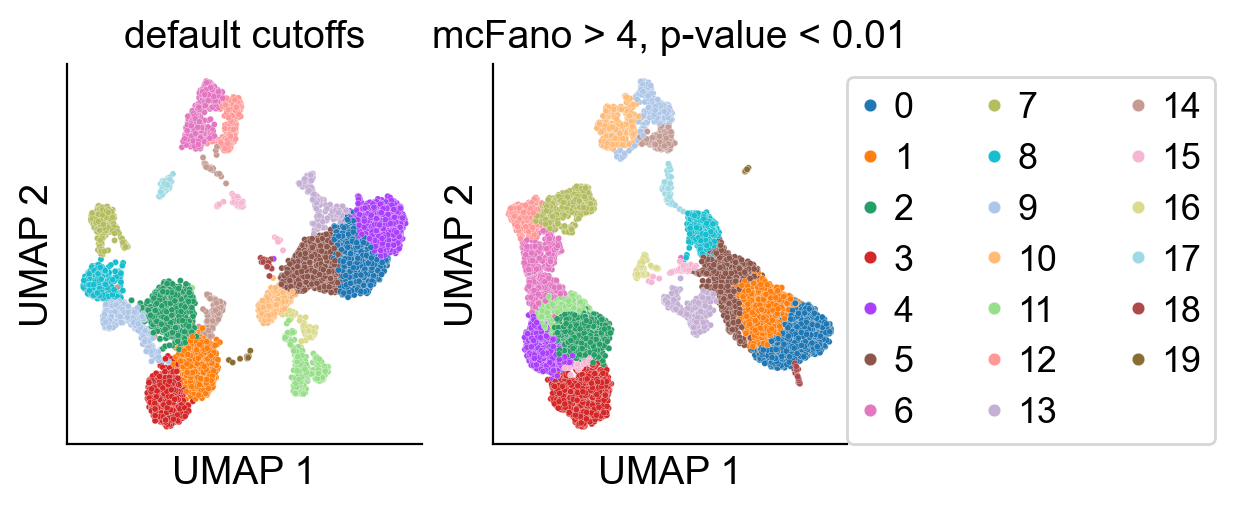

In [35]:
fig, axes = plt.subplots(1,2, figsize = (5, 2.5))

for col, key in enumerate(['default cutoffs', 'mcFano > 4, p-value < 0.01']):
    ax = axes[col]
    
    # Plot
    sns.scatterplot(x = pbmc.obsm[f'UMAP {key}'][:, 0], y = pbmc.obsm[f'UMAP {key}'][:, 1], hue = pbmc.obs[f'Leiden {key}'], ax = ax, s = 5, linewidth = 0.1)

    # Plot fixes

    ## x axis
    ax.set_xticklabels('')
    ax.set_xticks([])
    ax.set_xlabel('UMAP 1')

    ## y axis
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.set_ylabel('UMAP 2')

    ## Legend
    if col == 0:
        ax.legend().remove()
    else:
        ax.legend(loc = (1, 0), ncol = 3)

    ## Title
    ax.set_title(f'{key}')

    plt.grid(False)


## User can pick whether to limit the number of genes called as highly variable:

In [36]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, n_genes_for_PCA=400)

Using 400 top genes and 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


In [37]:
pbmc.var['highly_variable'].sum()

np.int64(400)

Note that by default if there is a conflict between the cutoffs and the number of genes requested by the user, BigSur will throw a warning and the cutoffs will win:

In [38]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, n_genes_for_PCA=10000)

Using 10000 top genes and 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


/Users/emmanueldollinger/Documents/Projects/BigSur/BigSur/feature_selection.py:211: UserWarning: Number of genes meeting cutoffs (1631) is lower than user requested genes (10000). Only including genes meeting cutoff in "highly_variable" slot. Please increase the min_mcfano_cutoff, decrease the p_val_cutoff, or set either or both to False.
  warnings.warn(


In [39]:
pbmc.var['highly_variable'].sum()

np.int64(1631)

## Specifying $p$-value cutoffs

The $p$-value cutoff can be disabled:

In [40]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, p_val_cutoff=None)

Using 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


We do NOT recommend turning off the $p$-value criterion; however, if the dataset is composed of groups of cells that are well-separated in gene expression space, the $p$-value cutoff isn't necessary (and can be faster computationally). Here we calculate features with and without $p$-value cutoffs, timing both. 

In [41]:
for p_value_cutoff in [0.05, None]:
    tick = time.time()
    mcfano_feature_selection(pbmc, layer='counts', p_val_cutoff=p_value_cutoff, verbose=0)
    tok = time.time()
    print(f'Execution of BigSur with p-value cutoff = {p_value_cutoff} was {np.round(tok - tick, 1)} seconds')
    sc.pp.pca(pbmc, key_added = f'X_pca p-value cutoff = {p_value_cutoff}')
    sc.pp.neighbors(pbmc, use_rep = f'X_pca p-value cutoff = {p_value_cutoff}', key_added=f'neighbors p-value cutoff = {p_value_cutoff}') # Specify the use_rep and key_added at each step, or the algorithm might default to another representation
    sc.tl.leiden(pbmc, neighbors_key=f'neighbors p-value cutoff = {p_value_cutoff}', key_added=f'Leiden p-value cutoff = {p_value_cutoff}')
    sc.tl.umap(pbmc, neighbors_key=f'neighbors p-value cutoff = {p_value_cutoff}', key_added = f'UMAP p-value cutoff = {p_value_cutoff}')

Execution of BigSur with p-value cutoff = 0.05 was 9.6 seconds
Execution of BigSur with p-value cutoff = None was 4.6 seconds


We can plot the resulting UMAPs and clusters:

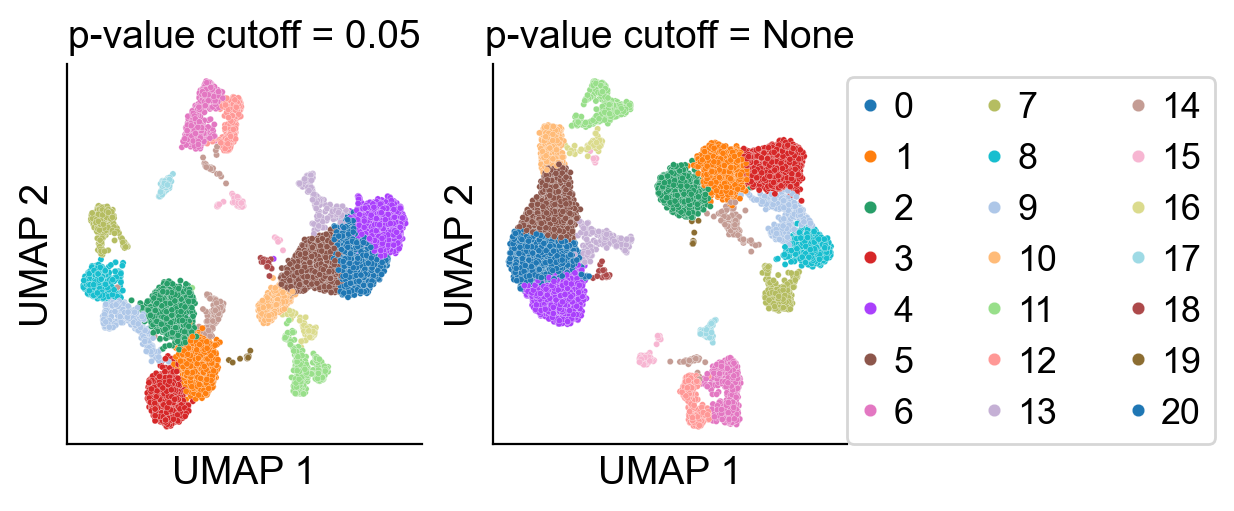

In [42]:
fig, axes = plt.subplots(1,2, figsize = (5, 2.5))

color_palette = {i: color for i, color in zip(np.array(list(range(21)), dtype = str), sns.color_palette(n_colors=21))}

for col, key in enumerate([0.05, None]):
    ax = axes[col]
    
    # Plot
    sns.scatterplot(x = pbmc.obsm[f'UMAP p-value cutoff = {key}'][:, 0], y = pbmc.obsm[f'UMAP p-value cutoff = {key}'][:, 1], hue = pbmc.obs[f'Leiden p-value cutoff = {key}'], ax = ax, s = 5, linewidth = 0.1, palette = color_palette)

    # Plot fixes

    ## x axis
    ax.set_xticklabels('')
    ax.set_xticks([])
    ax.set_xlabel('UMAP 1')

    ## y axis
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.set_ylabel('UMAP 2')

    ## Legend
    if col == 0:
        ax.legend().remove()
    else:
        ax.legend(loc = (1, 0), ncol = 3)

    ## Title
    ax.set_title(f'p-value cutoff = {key}')

    plt.grid(False)


In this case, the UMAPs and clusters calculated using either $p$-value cutoff are quite similar; however, this will not be true in all cases, especially with datasets with similar groups of cells or low statistical power (datasets with low numbers of cells or sequencing depth). 

## Fitting coefficient of variation

CV is the only fitted parameter in our model. We provide a way to fit CV, which is done by default.

In [43]:
mcfano_feature_selection(pbmc, layer='counts') # Fit CV 

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


However, if you already know what the CV is, you can pass that value and speed up the code.

In [44]:
mcfano_feature_selection(pbmc, layer='counts', cv = 0.55) # Provide CV 

Using 0.05 for pvalue cutoff and 0.9 for mcFano quantile cutoff for highly variable genes.


## Using mcResiduals for clustering

To calculate the modified corrected Fano factors, we first calculate residuals that have been modified to account for the expected variance of a Poisson Log-Normal distribution, and corrected for differential sequencing depth (i.e. mcResiduals). These mcResiduals can be used for dimensionality reduction and clustering. We show an example of how to do this on the CD8+ T cells, which were analyzed in the [Different usecases](#different-usecases) section, below. 

Since we've already analyzed this data, we will not redo the quality control steps (limiting the genes to those that are expressed in at least 3 cells, and limiting the cells to those that express at least 400 genes). We also determined that we should use a higher mcFano cutoff for these cells in that section.

### Using mcResiduals directly to calculate PCA and cluster

If return_residuals = True, the mcResiduals are stored in a layer of the AnnData called "residuals."

In [45]:
mcfano_feature_selection(cd8_t_cells, layer='counts', min_mcfano_cutoff=0.99, return_residuals=True) # The mcFano cutoff was determined in the Different usecases section.

Using 0.05 for pvalue cutoff and 0.99 for mcFano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


In [46]:
cd8_t_cells

AnnData object with n_obs × n_vars = 1384 × 15186
    obs: 'n_genes', 'Celltype', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mc_Fano', 'FDR_adj_pvalue', 'p_value', 'highly_variable'
    uns: 'log1p', 'CV_for_mc_Fano_fit', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'residuals'
    obsp: 'distances', 'connectivities'

To run PCA on these residuals, simply call:

In [47]:
sc.pp.pca(cd8_t_cells, layer = 'residuals') # Run PCA on the residuals

We can now calculate neighbors and UMAP coordinates and assign clusters using the Leiden algorithm.

In [48]:
sc.pp.neighbors(cd8_t_cells)
sc.tl.umap(cd8_t_cells)
sc.tl.leiden(cd8_t_cells)

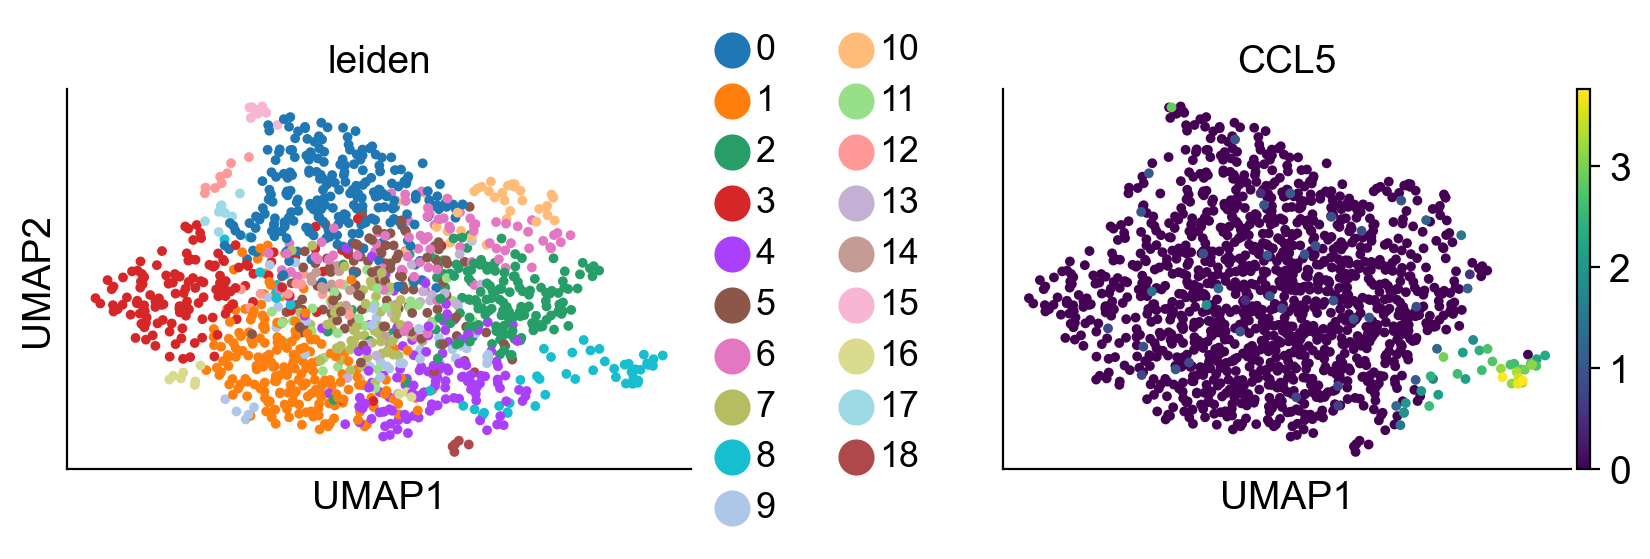

In [49]:
fig, axes = plt.subplots(1,2, figsize = (10, 2.5))
for row, color in enumerate(['leiden', 'CCL5']):
    ax = axes[row]
    
    # Plot
    sc.pl.umap(cd8_t_cells, color = color, ax = ax, show = False, s = 50)

    # Plot fixes

    ## y axis
    if row != 0:
        ax.set_ylabel('')
    

    ## Title
    ax.set_title(f'{color}')

plt.subplots_adjust(wspace = 0.5)

### Using a psuedo-count matrix calculated from the mcResiduals to cluster

The mcResiduals tend to be heavy-tailed, which could cause issues when calculating the priniciple components (PCs). The common solution to calculating PCs on heavy-tailed distributions is to first make them more normally-distributed by taking the logarithm of the values. However, the mcResiduals (as with all residuals) are mean-centered around zero. We can therefore create a "psuedocount" matrix from the mcResiduals, which will be strictly positive. 

To create the "psuedocount" matrix, we will multiply the mcResiduals by the square root of mean of the counts, and to that product add the mean of the counts:

$\text{psuedomatrix}_{ij} = \text{mcResiduals}_{ij} * \sqrt{\bar{x_{j}}} + \bar{x_{j}}$, where $\text{mcResiduals}_{ij}$ is the mcResidual of gene $j$ in cell $i$ and $\bar{x_{j}} = \frac{1}{n} \sum_i x_{ij}$ is the mean of the gene $j$ counts.

We will store this psuedocount matrix in the Anndata, as follows:

In [50]:
gene_means = np.array(cd8_t_cells.layers['counts'].mean(axis=0)).flatten()

cd8_t_cells.layers['psuedocount matrix'] = cd8_t_cells.layers['residuals'] * np.sqrt(gene_means) + gene_means # Create psuedocount matrix

Before taking the logarithm of these psuedocounts, we need to ensure that the values are strictly positive. To do so, we will add one to each value, and threshold the resulting minimum value to be no smaller than $10^{-5}$.

In [51]:
psuedocount_matrix_strictly_positive = cd8_t_cells.layers['psuedocount matrix'] + 1
psuedocount_matrix_strictly_positive[psuedocount_matrix_strictly_positive <= 0] = 1e-5

Now we can take the logarithm, and store these values.

In [52]:
cd8_t_cells.layers['logged psuedocount matrix'] = np.log(psuedocount_matrix_strictly_positive) # Take logarithm of psuedocount matrix

The full code, without annotation, is:

In [53]:
adata = cd8_t_cells

gene_means = np.array(adata.layers['counts'].mean(axis=0)).flatten()

adata.layers['psuedocount matrix'] = adata.layers['residuals'] * np.sqrt(gene_means) + gene_means # Create psuedocount matrix

psuedocount_matrix_strictly_positive = adata.layers['psuedocount matrix'] + 1
psuedocount_matrix_strictly_positive[psuedocount_matrix_strictly_positive <= 0] = 1e-5

adata.layers['logged psuedocount matrix'] = np.log(psuedocount_matrix_strictly_positive) # Take logarithm of psuedocount matrix

Now we can calculate the PCs as above. 

In [54]:
sc.pp.pca(cd8_t_cells, layer = 'logged psuedocount matrix') # Run PCA on the residuals
sc.pp.neighbors(cd8_t_cells)
sc.tl.umap(cd8_t_cells)
sc.tl.leiden(cd8_t_cells, key_added = 'leiden on PCA from logged psuedocount matrix')

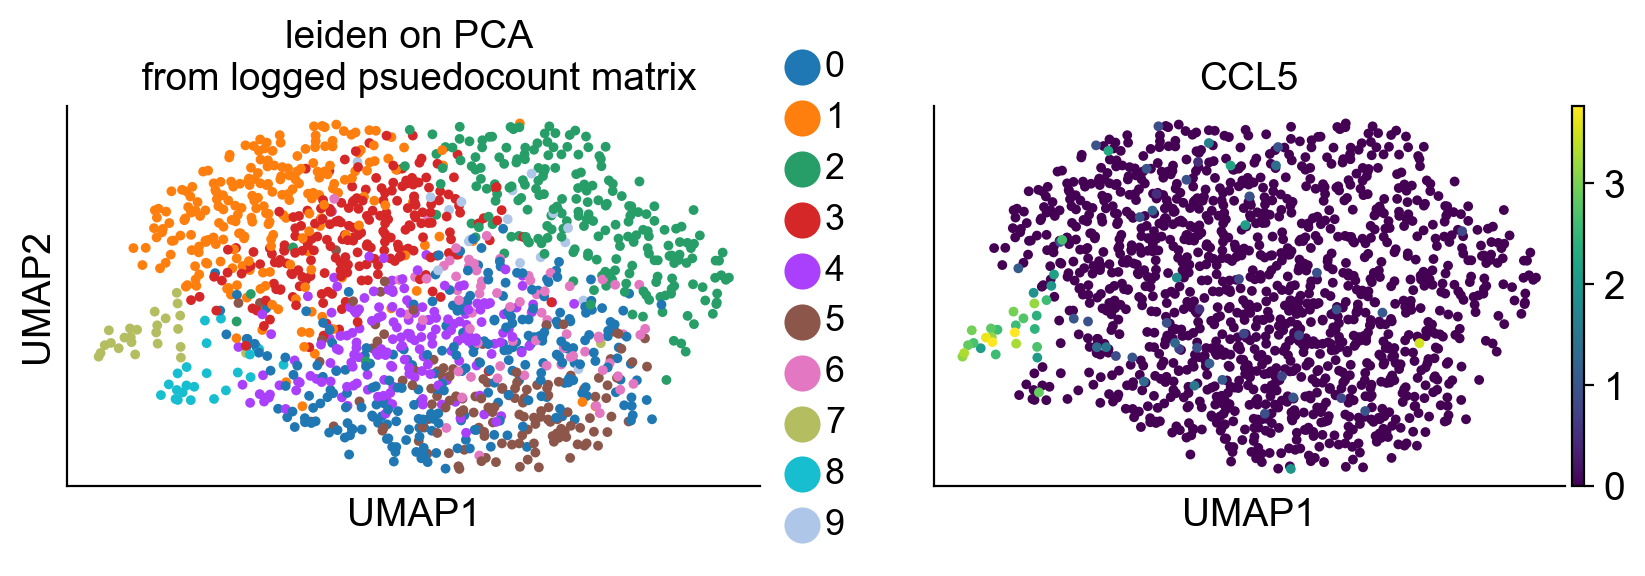

In [55]:
fig, axes = plt.subplots(1,2, figsize = (10, 2.5))
for row, color in enumerate(['leiden on PCA from logged psuedocount matrix', 'CCL5']):
    ax = axes[row]
    
    # Plot
    sc.pl.umap(cd8_t_cells, color = color, ax = ax, show = False, s = 50)

    # Plot fixes
    ## y axis
    if row != 0:
        ax.set_ylabel('')
    
    ## Title
    if color == 'leiden on PCA from logged psuedocount matrix':
        ax.set_title(f'leiden on PCA \n from logged psuedocount matrix')

plt.subplots_adjust(wspace = 0.25)

# Docstring of feature selection function

In [56]:
?mcfano_feature_selection

Signature:
mcfano_feature_selection(
    adata: anndata._core.anndata.AnnData,
    layer: str,
    cv: Union[bool, float] = None,
    n_genes_for_PCA: Union[bool, int] = False,
    min_mcfano_cutoff: Union[bool, float] = 0.9,
    p_val_cutoff: Union[bool, float] = 0.05,
    return_residuals: bool = False,
    n_jobs: int = -2,
    verbose: int = 1,
)
Docstring:
Calculate the modified corrected Fano factor for all genes in the dataset. mc_Fano column will be added to .var. Highly_variable column will be added to .var based on the n_genes_for_pca, min_mcfano_cutoff and p_val_cutoff parameters.

Parameters
----------
adata - adata object containing information about the raw counts and gene names.
layer - String, describing the layer of adata object containing raw counts (pass "X" if raw counts are in adata.X).
cv - Float, coefficient of variation for the given dataset. If None, the CV will be estimated.
n_genes_for_PCA - [Int, Bool], top number of genes to use for highly_variable slot, ra

# Packages contained in the conda environment

There are many packages in the environment. If you're having trouble installing this conda environment, you can create a lightweight environment by typing (in Terminal):

    conda create -n bigsur -c conda-forge scanpy mpmath numexpr ipykernel python-igraph leidenalg

In [57]:
!cat environment.yml

name: bigsur
channels:
  - conda-forge
dependencies:
  - _r-mutex=1.0.1=anacondar_1
  - anndata=0.11.4=pyhd8ed1ab_0
  - appnope=0.1.4=pyhd8ed1ab_1
  - arpack=3.9.1=nompi_h1f29f7c_102
  - array-api-compat=1.12.0=pyhe01879c_0
  - asttokens=3.0.0=pyhd8ed1ab_1
  - brotli=1.1.0=h5505292_3
  - brotli-bin=1.1.0=h5505292_3
  - bwidget=1.10.1=hce30654_1
  - bzip2=1.0.8=h99b78c6_7
  - c-ares=1.34.5=h5505292_0
  - ca-certificates=2025.6.15=hbd8a1cb_0
  - cached-property=1.5.2=hd8ed1ab_1
  - cached_property=1.5.2=pyha770c72_1
  - cairo=1.18.4=h6a3b0d2_0
  - cctools_osx-arm64=1010.6=h729f01a_6
  - clang=20.1.7=default_hcdeef69_0
  - clang-20=20.1.7=default_h03658f6_0
  - clang_impl_osx-arm64=20.1.7=h5bfba70_25
  - clang_osx-arm64=20.1.7=h07b0088_25
  - clangxx=20.1.7=default_haca757a_0
  - clangxx_impl_osx-arm64=20.1.7=h12301e7_25
  - clangxx_osx-arm64=20.1.7=h07b0088_25
  - colorama=0.4.6=pyhd8ed1ab_1
  - comm=0.2.2=pyhd8ed1ab_1
  - compiler-rt=20.1.7=hd2aecb6_0
  - compiler-rt_osx-arm64=20.1.7=h7